In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [19]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_nfmc(2000, optim_iter=1000, nf_iter=20, chains=1,
                           frac_validate=0.2, alpha=(0.75,0.75), parallel=False,
                           ftol=1.0e-12, NBfirstlayer=True)
    az_trace = az.from_pymc3(trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1, Normalizing Constant Estimate: 0.0016528111886588155
Stage:   2, Normalizing Constant Estimate: 0.0035914652137459388


0.5397947382776083


Stage:   3, Normalizing Constant Estimate: 0.0037583962814646643


0.04441550470395626


Stage:   4, Normalizing Constant Estimate: 0.00388447814917977


0.0324578650910235


Stage:   5, Normalizing Constant Estimate: 0.0038258562550689255


0.015322555319002255


Stage:   6, Normalizing Constant Estimate: 0.003675899392846903


0.04079460458407279


Stage:   7, Normalizing Constant Estimate: 0.0038800379553267936


0.052612516895520246


Stage:   8, Normalizing Constant Estimate: 0.003736314654857907


0.038466594424005296


Stage:   9, Normalizing Constant Estimate: 0.003911734806446352


0.044844592046311624


Stage:  10, Normalizing Constant Estimate: 0.0037116672452111262


0.053902343075973976


Stage:  11, Normalizing Constant Estimate: 0.003984690002349847


0.06851794166615569


Stage:  12, Normalizing Constant Estimate: 0.003905507548843832


0.020274561632701436
0.0035108209898109632
Normalizing constant estimate has stabilised - ending NF fits.


In [20]:
nf_evidence = trace.report.evidence
print(f'NFMC calculated evidence: {nf_evidence[0]}')
importance_weights = trace.report.importance_weights
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.0039192673950791575
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.200  0.464  -0.673    0.596      0.011    0.007    1948.0  1948.0   
X[1] -0.198  0.469  -0.680    0.614      0.011    0.008    1990.0  1927.0   
X[2] -0.205  0.471  -0.676    0.622      0.011    0.007    1972.0  1972.0   
X[3] -0.199  0.468  -0.666    0.628      0.010    0.007    2048.0  2030.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1995.0    1921.0    NaN  
X[1]    2003.0    1779.0    NaN  
X[2]    1950.0    1867.0    NaN  
X[3]    2267.0    1880.0    NaN  


<Figure size 720x480 with 0 Axes>

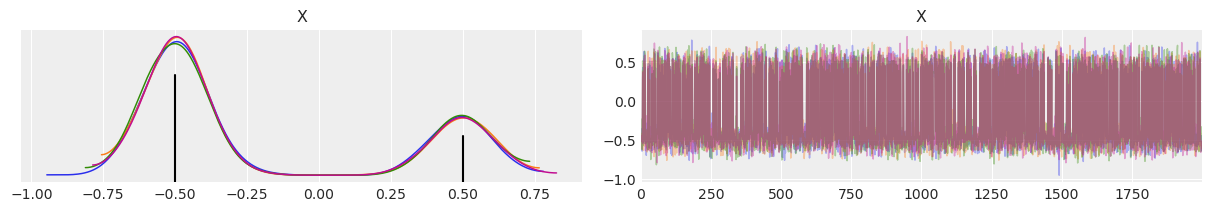

In [21]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

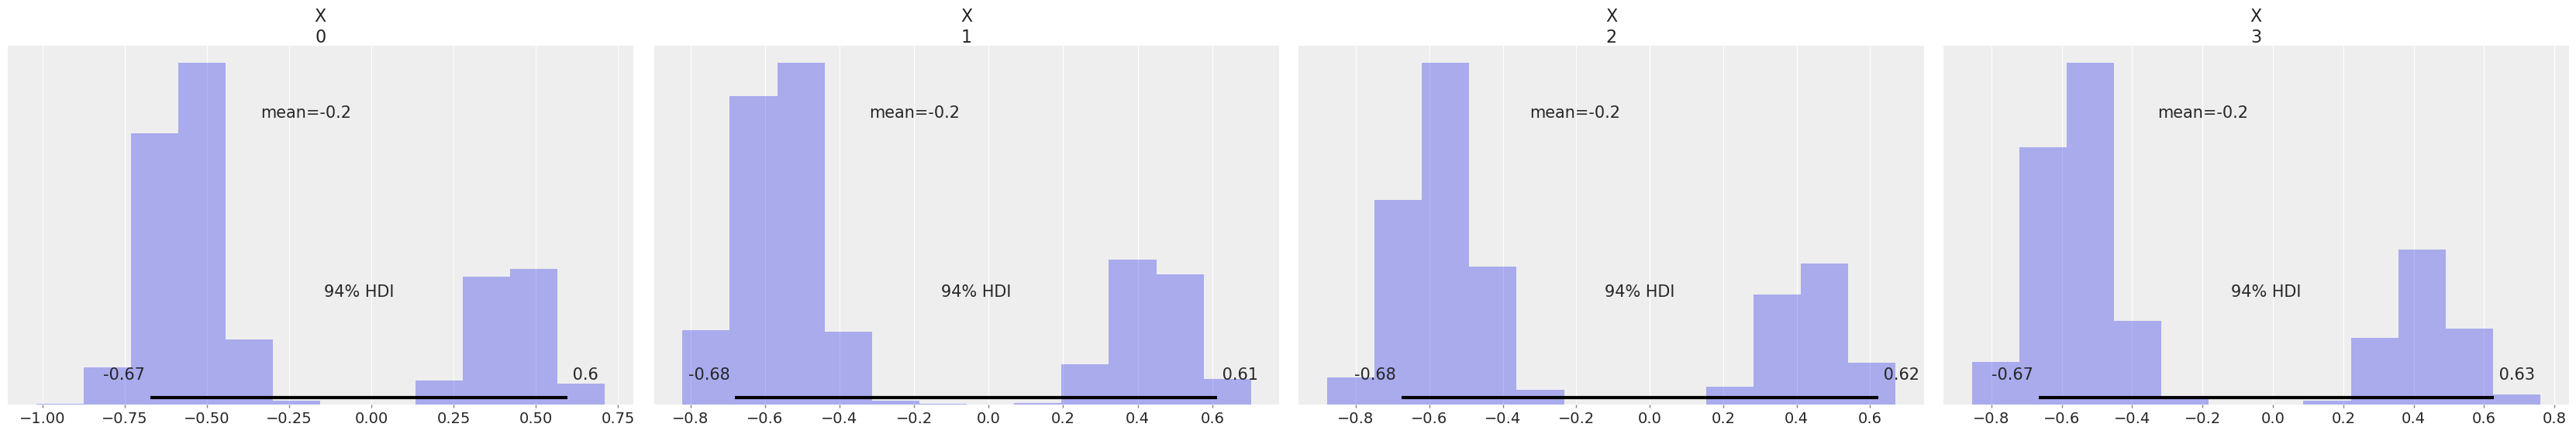

In [22]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


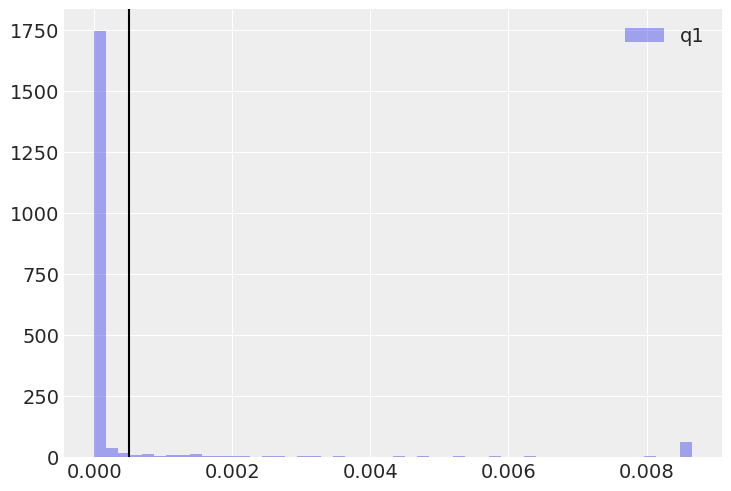

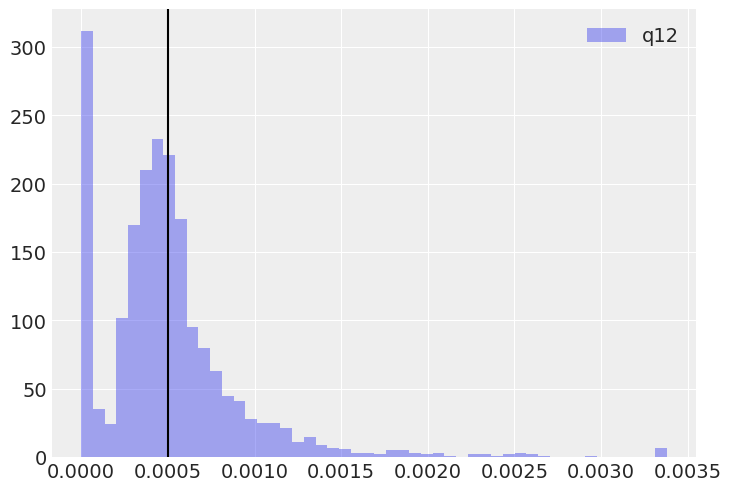

In [25]:
plt.figure()
sns.distplot(importance_weights[0][:2000], kde=False, label='q1')
plt.axvline(x=1/2000, color='k')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(importance_weights[0][(2000*12):], kde=False, label='q12')
plt.axvline(x=1/2000, color='k')
plt.legend(loc='upper right')
plt.show()

Let's just check these results against those from SMC. 

In [9]:
with model:
    smc_trace = pm.sample_smc(2000)
    az_smc_trace = az.from_pymc3(smc_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.063
Stage:   3 Beta: 0.137
Stage:   4 Beta: 0.302
Stage:   5 Beta: 0.672
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.067
Stage:   3 Beta: 0.146
Stage:   4 Beta: 0.318
Stage:   5 Beta: 0.694
Stage:   6 Beta: 1.000


In [10]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00434145 0.00464217]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.212  0.466  -0.662    0.638      0.008    0.005    3643.0  3643.0   
X[1] -0.210  0.464  -0.680    0.613      0.008    0.005    3721.0  3721.0   
X[2] -0.209  0.463  -0.681    0.600      0.008    0.005    3791.0  3791.0   
X[3] -0.209  0.466  -0.674    0.619      0.008    0.005    3775.0  3775.0   

      ess_bulk  ess_tail  r_hat  
X[0]    3443.0    3619.0    1.0  
X[1]    3860.0    3587.0    1.0  
X[2]    3856.0    3872.0    1.0  
X[3]    3927.0    3731.0    1.0  


<Figure size 720x480 with 0 Axes>

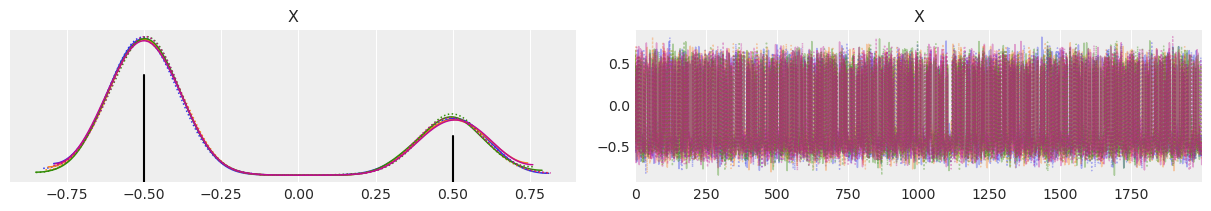

In [11]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

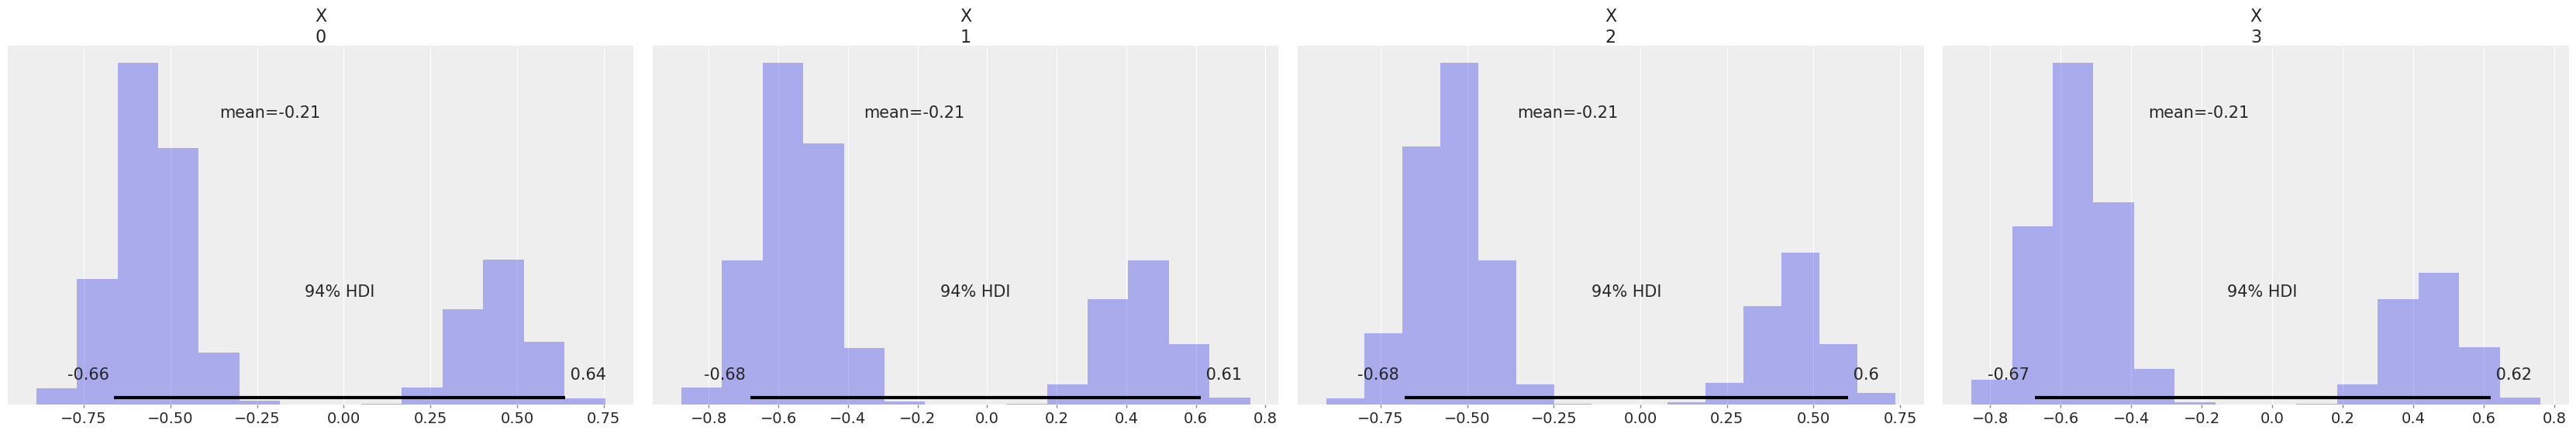

In [12]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

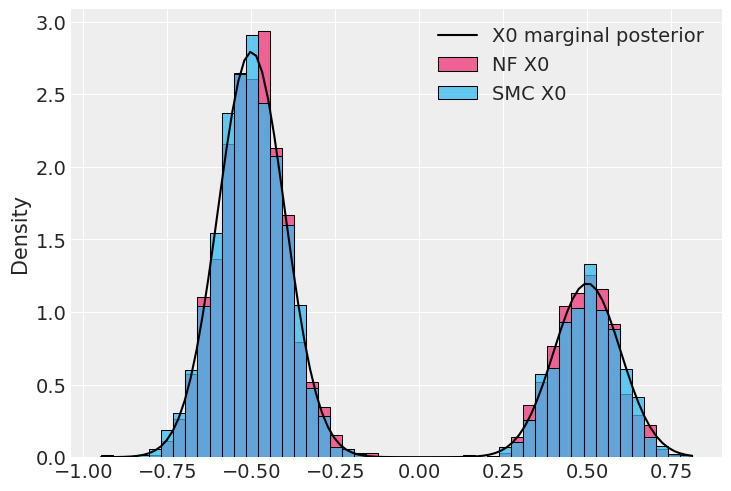

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [24]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

'''
plt.figure()
sns.distplot(nf_x1, label='NF X1')
sns.distplot(smc_x1, label='SMC X1')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x2, label='NF X2')
sns.distplot(smc_x2, label='SMC X2')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x3, label='NF X3')
sns.distplot(smc_x3, label='SMC X3')
plt.legend(loc='upper right')
plt.show()
'''

In [26]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    rg_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1, Normalizing Constant Estimate: 81.45913855834985
Stage:   2, Normalizing Constant Estimate: 319.01741268623874


0.7446561368784379


Stage:   3, Normalizing Constant Estimate: 338.22782554597353


0.05679725737740527


Stage:   4, Normalizing Constant Estimate: 357.1648842710768


0.05302049434045326


Stage:   5, Normalizing Constant Estimate: 346.1961248501927


0.031683657422885814


Stage:   6, Normalizing Constant Estimate: 350.4153973695894


0.01204077375329082
0.0008619068078586698
Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

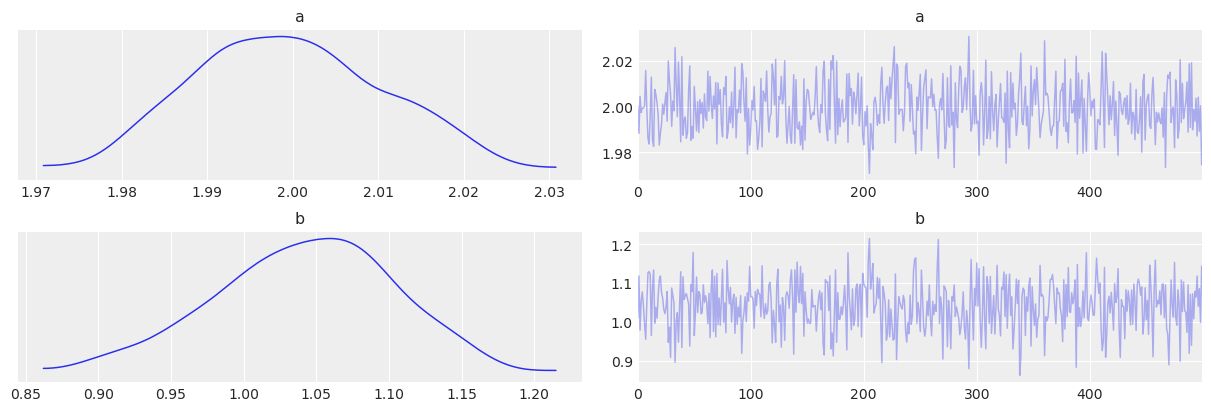

In [27]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


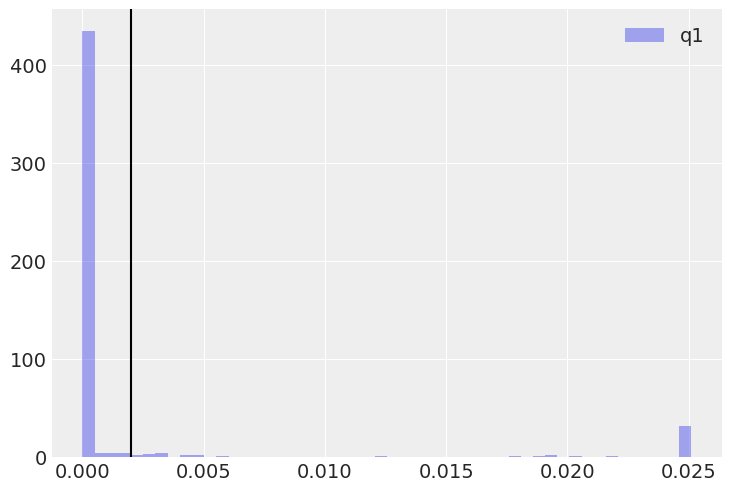

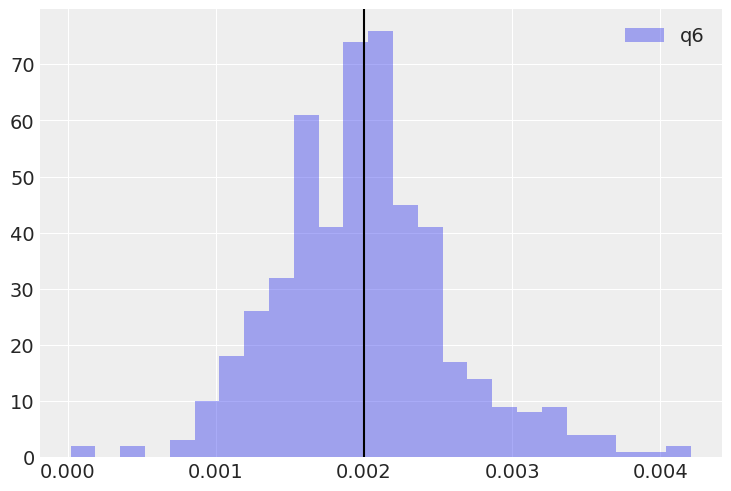

In [28]:
rg_importance_weights = rg_trace.report.importance_weights

plt.figure()
sns.distplot(rg_importance_weights[0][:500], kde=False, label='q1')
plt.axvline(x=0.002, color='k')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(rg_importance_weights[0][500*6:], kde=False, label='q6')
plt.axvline(x=0.002, color='k')
plt.legend(loc='upper right')
plt.show()

In [16]:
with rg_model:
    nuts_trace = pm.sample(2000)
    nuts_az_trace = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

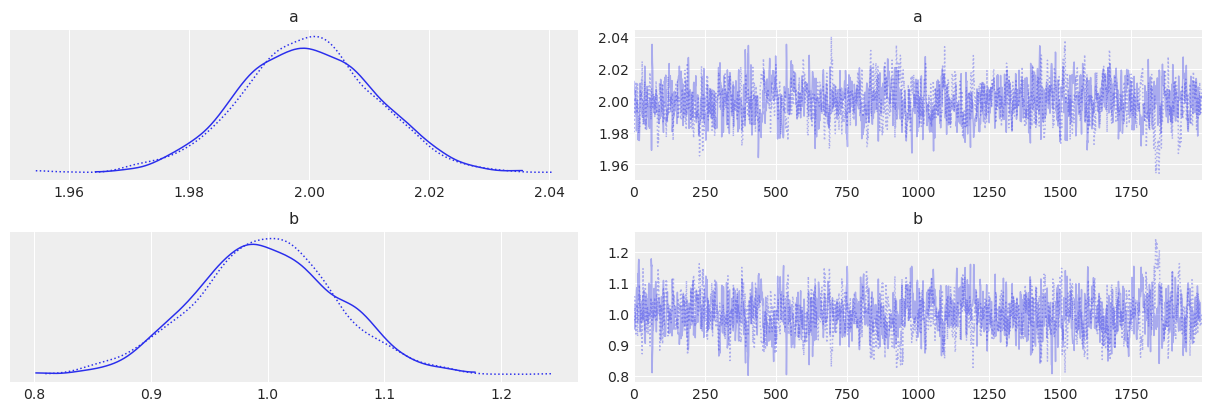

In [17]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

In [18]:
with rg_model:
    smc_rg_trace = pm.sample_smc(2000)
    az_smc_rg_trace = az.from_pymc3(smc_rg_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.032
Stage:   4 Beta: 0.113
Stage:   5 Beta: 0.381
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.030
Stage:   4 Beta: 0.105
Stage:   5 Beta: 0.355
Stage:   6 Beta: 1.000


<Figure size 720x480 with 0 Axes>

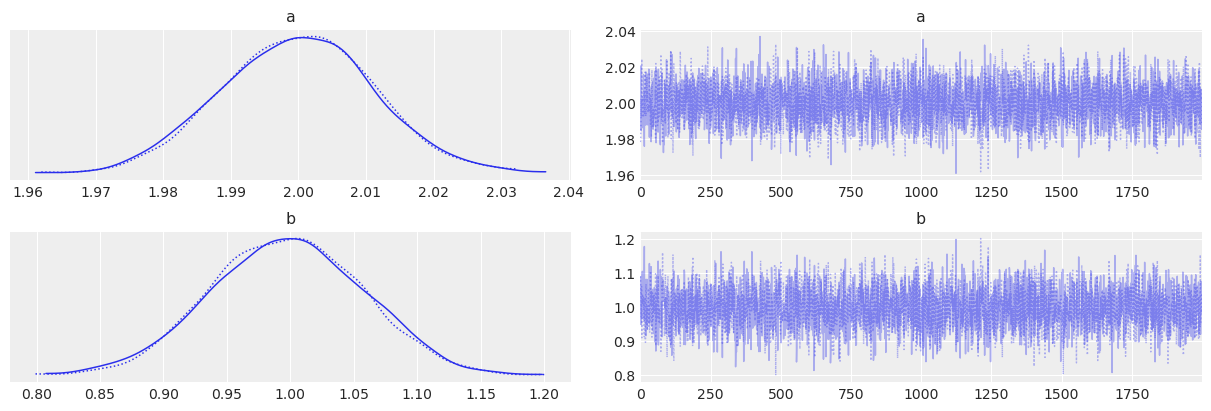

In [19]:
plt.figure()
az.plot_trace(az_smc_rg_trace)
plt.show()

In [22]:
smc_rg_evidence = np.exp(smc_rg_trace.report.log_marginal_likelihood)
print(f'SMC linear regression evidence: {smc_rg_evidence}')

SMC linear regression evidence: [344.4154393  317.38750233]


In [34]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(354.59987396636336, 2.8861844823404627e-05)


Hierarchical Radon Model ....

In [36]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [37]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [39]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

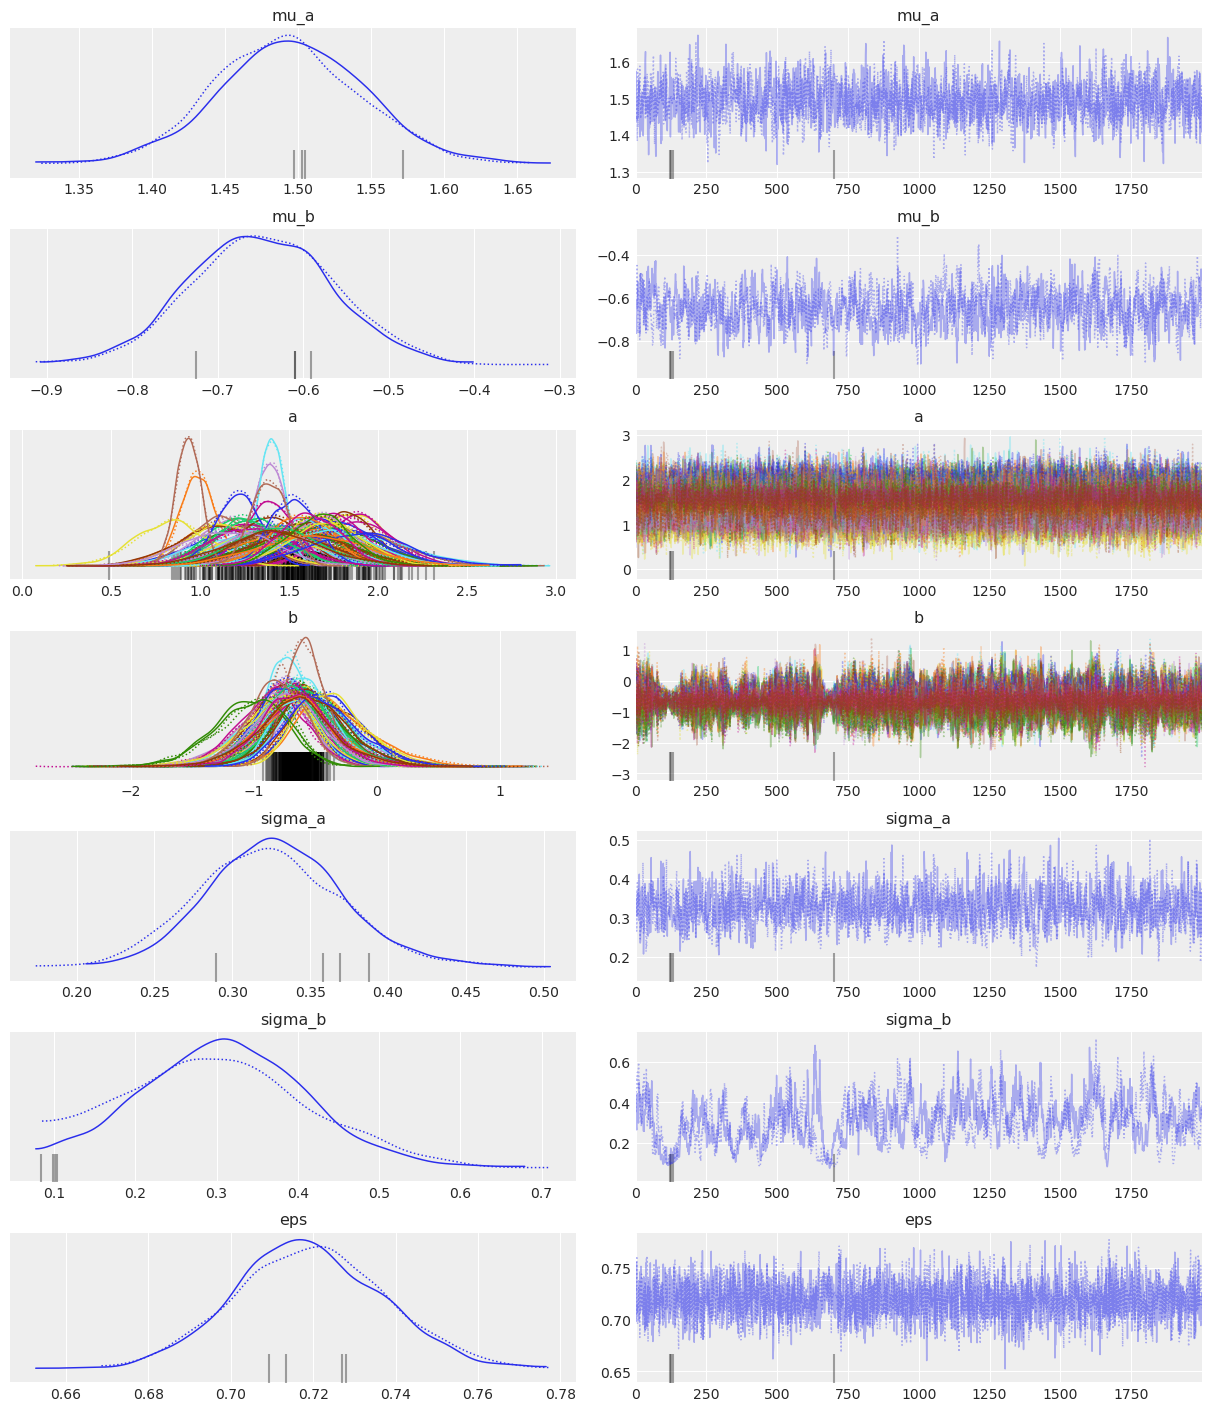

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 